In [1]:
import numpy as np
from extraction_tools import SpectralExtraction, combine_extractions

filters = {'g235h': 'f170lp', 'g395h': 'f290lp', 'g140h': 'f100lp'}

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/net/lem/data1/regt/retrieval_base/JWST_VHS_1256B/extraction_tools.py:175: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)


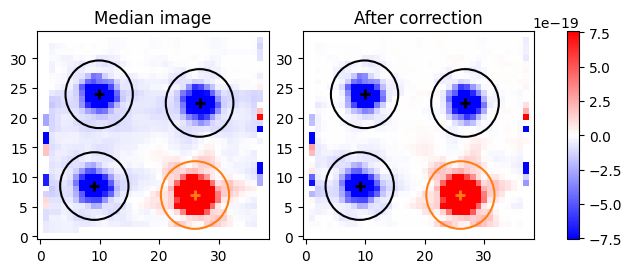

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/net/lem/data1/regt/retrieval_base/JWST_VHS_1256B/extraction_tools.py:175: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)


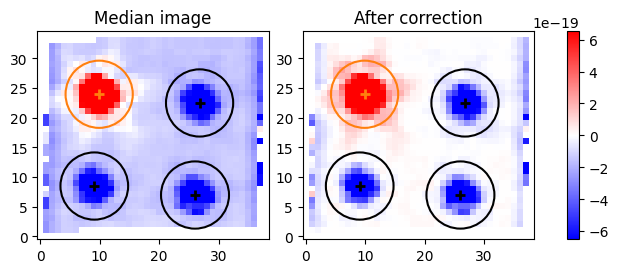

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/net/lem/data1/regt/retrieval_base/JWST_VHS_1256B/extraction_tools.py:175: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)


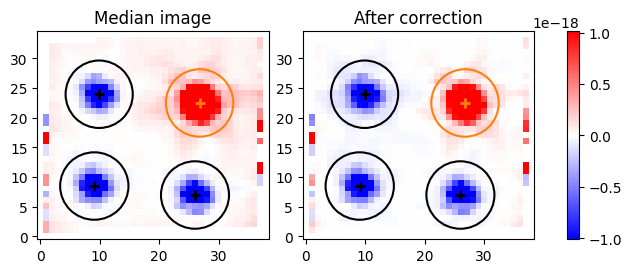

/net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/net/lem/data1/regt/retrieval_base/JWST_VHS_1256B/extraction_tools.py:175: RuntimeWarning: All-NaN slice encountered
  horizontal_collapsed = np.nanmedian(masked_cube, axis=2, keepdims=True)


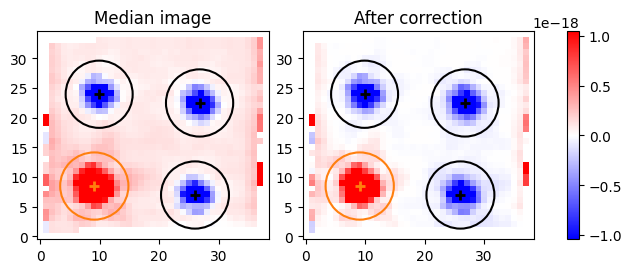

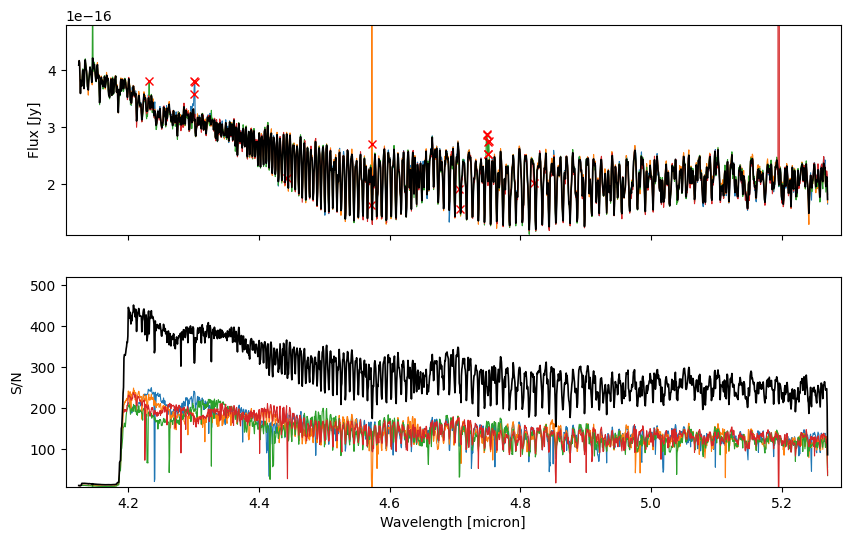

In [7]:
# filename = './NIRSPEC_ifu_data_01386/stage2/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
# filename = '/net/schenk/data2/regt/JWST_reductions/MAST_stage2_31_07_2025/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
filename = '/net/schenk/data2/regt/JWST_reductions/NIRSPEC_ifu_data_01386/stage2/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
grating = 'g395h'
detector = 'nrs2'

SEs = []
AC = None # No aperture correction has been calculated yet
for dither in [1,2,3,4]:
    if grating == 'g140h':
        file_s3d = filename.format('03106', dither, detector, 's3d')
        file_x1d = filename.format('03106', dither, detector, 'x1d')
    elif grating == 'g235h':
        file_s3d = filename.format('03102', dither, detector, 's3d')
        file_x1d = filename.format('03102', dither, detector, 'x1d')
    elif grating == 'g395h':
        file_s3d = filename.format('03104', dither, detector, 's3d')
        file_x1d = filename.format('03104', dither, detector, 'x1d')

    SE = SpectralExtraction(
        file_s3d=file_s3d, file_wave=file_x1d, 
        disperser=grating.upper(), filter=filters[grating], AC=AC,
    )
    SE.correct_horizontal_stripes((9, 8), (26, 7), (10, 24), (27, 23), radius_inflation=6, plot=True)
    SE.extract_1d(radius_inflation=4, plot=False)

    SEs.append(SE); AC = SE.AC # Re-use the aperture correction

# Combine the dithering positions and save
wave_combined, flux_combined, flux_err_combined = \
    combine_extractions(*SEs, sigma_clip=20, plot=True)#, xlim=(2.18, 2.23))
np.savetxt(
    '/net/schenk/data2/regt/JWST_reductions/Miles_ea_2023/reduction_31_07_2025/nirspec_{}_{}.dat'.format(grating[1:], detector[-1]), 
    np.array([wave_combined, flux_combined, flux_err_combined]).T, delimiter=',', 
    header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
    )

In [ ]:
combine_extractions(*SEs, sigma_clip=20, plot=True, xlim=(5.2,5.3))